In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# ----------------------------
# Cost Functions (L1, L2, L∞)
# ----------------------------
def cost_l1(x_old, x_new):
    return np.sum(np.abs(x_new - x_old))

def cost_l2(x_old, x_new):
    return np.linalg.norm(x_new - x_old)

def cost_linf(x_old, x_new):
    return np.max(np.abs(x_new - x_old))


# ----------------------------
# Reward Function (Variant B only)
# ----------------------------
# Reward 1 for accepted, -1 for denied.
def reward_function(label):
    return 1 if label == 1 else -1


# ----------------------------
# Agent Class
# ----------------------------
class Agent:
    def __init__(self, features, true_label=None):
        self.features = features
        self.initial_features = features.copy()  # store original position for visualization
        self.true_label = true_label             # assigned by the true classifier
        self.modified = False                    # whether agent has modified its features
        self.explored = False                    # whether the agent participated in exploration

    def modify_features(self, modification, cost_func):
        new_features = self.features + modification
        c = cost_func(self.features, new_features)
        self.features = new_features
        self.modified = True
        return c


# ----------------------------
# Simulation Environment Class
# ----------------------------
class SimulationEnv:
    def __init__(self,
                 hidden_dim=10,
                 num_agents=100,
                 cost_function='l1'):
        self.hidden_dim = hidden_dim
        self.num_agents = num_agents

        # Map cost function string to function.
        self.cost_functions = {'l1': cost_l1, 'l2': cost_l2, 'linf': cost_linf}
        if cost_function not in self.cost_functions:
            raise ValueError("Unsupported cost function. Choose from 'l1', 'l2', or 'linf'.")
        self.cost_func = self.cost_functions[cost_function]

        # ----------------------------
        # True (Hidden) Classifier
        # ----------------------------
        self.classifier_weights = np.random.randn(hidden_dim)
        self.classifier_bias = np.random.randn()

        # ----------------------------
        # Proposed Classifier (SVM)
        # ----------------------------
        # This will be trained on exploration data.
        self.proposed_svm = None

        # Containers to hold exploration data.
        self.exploration_data_X = []
        self.exploration_data_y = []

        # Generate the agent community; each agent's true label is determined by the hidden classifier.
        self.agents = self.generate_agents()

    def generate_agents(self):
        agents = []
        for _ in range(self.num_agents):
            features = np.random.randn(self.hidden_dim)
            # Compute the score using the hidden classifier.
            score = np.dot(features, self.classifier_weights) + self.classifier_bias
            # Label assignment: accepted if score >= 0, denied otherwise (Variant B).
            label = 1 if score >= 0 else -1
            agent = Agent(features, true_label=label)
            agents.append(agent)
        return agents

    def classify_agent(self, agent):
        """
        Classify an agent using the true (hidden) classifier.
        """
        score = np.dot(agent.features, self.classifier_weights) + self.classifier_bias
        return 1 if score >= 0 else -1

    def proposed_predict(self, features):
        """
        Predict label using the proposed SVM classifier.
        """
        if self.proposed_svm is None:
            raise ValueError("Proposed SVM has not been trained yet.")
        score = self.proposed_svm.decision_function(features.reshape(1, -1))[0]
        return 1 if score >= 0 else -1

    def train_proposed_classifier(self):
        """
        Train (or retrain) the proposed classifier using the accumulated exploration data.
        """
        if len(self.exploration_data_X) == 0:
            return
        X = np.array(self.exploration_data_X)
        y = np.array(self.exploration_data_y)
        # Using a linear SVM. Adjust C to control regularization.
        self.proposed_svm = SVC(kernel='linear', C=1.0)
        self.proposed_svm.fit(X, y)

    def simulation_step(self):
        """
        Update the true labels for all agents based on current features.
        """
        for agent in self.agents:
            agent.true_label = self.classify_agent(agent)

    def run_exploration_phase(self, exploration_budget=10):
        """
        Exploration phase:
        A random subset of agents (up to exploration_budget) query the true classifier.
        Their features and true labels are stored and used to train the proposed SVM.
        """
        total_exploration_cost = 0
        num_to_explore = min(exploration_budget, len(self.agents))
        chosen_agents = np.random.choice(self.agents, size=num_to_explore, replace=False)
        for agent in chosen_agents:
            true_label = self.classify_agent(agent)
            agent.true_label = true_label
            agent.explored = True
            self.exploration_data_X.append(agent.features.copy())
            self.exploration_data_y.append(true_label)
            total_exploration_cost += 1
        self.train_proposed_classifier()
        return total_exploration_cost

    def apply_investment(self, agent, modification):
        """
        Exploitation phase:
        The agent applies a modification.
        After modification, the true label is re-computed and utility is calculated.
        """
        cost_incurred = agent.modify_features(modification, self.cost_func)
        new_true_label = self.classify_agent(agent)
        reward = reward_function(new_true_label)
        utility = reward - cost_incurred
        return utility, cost_incurred, reward, new_true_label

    def run_exploitation_phase(self):
        """
        For each agent that is not accepted by the true classifier and did not participate in exploration,
        determine the optimal modification required so that the proposed SVM predicts acceptance.
        The agent chooses the smallest modification (in the direction of the SVM's weight vector)
        that makes f_proposed(new_features) >= 0.
        If the cost of this modification is lower than the perceived gain (i.e. if cost < 2),
        the agent invests. Otherwise, it does nothing.
        For agents that already participated in exploration, record their utility based on their true label.
        """
        utilities = []
        gain_threshold = 2  # Modification is beneficial if cost < 2.
        for agent in self.agents:
            # For agents that already explored, record utility based on current true label.
            if agent.explored:
                utilities.append(reward_function(agent.true_label))
                continue

            true_label = self.classify_agent(agent)
            # If agent is already accepted by the true classifier, no need to modify.
            if true_label == 1:
                utilities.append(reward_function(true_label))
                continue

            # Check if we have a trained proposed classifier.
            if self.proposed_svm is None:
                utilities.append(reward_function(true_label))
                continue

            # Compute the SVM's decision function.
            f_prop = self.proposed_svm.decision_function(agent.features.reshape(1, -1))[0]
            if f_prop >= 0:
                utilities.append(reward_function(true_label))
            else:
                # For a linear SVM, the gradient is given by the weight vector.
                weight_vector = self.proposed_svm.coef_[0]
                norm_w = np.linalg.norm(weight_vector)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                    norm_w = 1
                else:
                    d_unit = weight_vector / norm_w
                # Minimal scaling factor alpha required to bring f_proposed to zero.
                alpha_min = -f_prop / norm_w
                projected_features = agent.features + alpha_min * d_unit
                projected_cost = self.cost_func(agent.features, projected_features)
                if projected_cost < gain_threshold:
                    util, cost_val, reward_val, new_true_label = self.apply_investment(agent, alpha_min * d_unit)
                    utilities.append(util)
                    # Update the exploration data with the modified agent's new state.
                    self.exploration_data_X.append(agent.features.copy())
                    self.exploration_data_y.append(new_true_label)
                    # Retrain the SVM with the updated exploration data.
                    self.train_proposed_classifier()
                else:
                    utilities.append(reward_function(true_label))
        return utilities

    def plot_environment(self):
        """
        Plot agents (as dots), the true classifier's decision boundary, 
        the proposed SVM decision boundary, and mark agents that modified their features.
        For each modified agent, draw an arrow from its initial position to its current position.
        Only works when hidden_dim == 2.
        """
        if self.hidden_dim != 2:
            print("Plotting is only supported for hidden_dim = 2.")
            return

        self.simulation_step()

        accepted = []
        denied = []
        modified_points = []
        for agent in self.agents:
            label = self.classify_agent(agent)
            if label == 1:
                accepted.append(agent.features)
            else:
                denied.append(agent.features)
            if agent.modified:
                modified_points.append(agent.features)
        accepted = np.array(accepted) if accepted else np.empty((0, 2))
        denied = np.array(denied) if denied else np.empty((0, 2))
        modified_points = np.array(modified_points) if modified_points else np.empty((0, 2))

        plt.figure(figsize=(8, 6))
        if accepted.size > 0:
            plt.scatter(accepted[:, 0], accepted[:, 1], c='green', label='Accepted')
        if denied.size > 0:
            plt.scatter(denied[:, 0], denied[:, 1], c='red', label='Denied')

        if modified_points.size > 0:
            plt.scatter(modified_points[:, 0], modified_points[:, 1],
                        facecolors='none', edgecolors='blue', s=100, linewidths=1.5,
                        label='Modified Agents')

        for agent in self.agents:
            if agent.modified:
                x_old, y_old = agent.initial_features[0], agent.initial_features[1]
                x_new, y_new = agent.features[0], agent.features[1]
                plt.arrow(x_old, y_old, x_new - x_old, y_new - y_old,
                          head_width=0.05, head_length=0.1, fc='blue', ec='blue', alpha=0.7)

        all_features = np.array([agent.features for agent in self.agents])
        x_min, x_max = np.min(all_features[:, 0]) - 1, np.max(all_features[:, 0]) + 1
        x_values = np.linspace(x_min, x_max, 100)

        # Plot the true classifier's decision boundary.
        if self.classifier_weights[1] != 0:
            y_values = (-self.classifier_bias - self.classifier_weights[0] * x_values) / self.classifier_weights[1]
            plt.plot(x_values, y_values, 'b--', label='True Decision Boundary')
        else:
            x_boundary = -self.classifier_bias / self.classifier_weights[0]
            plt.axvline(x=x_boundary, color='b', linestyle='--', label='True Decision Boundary')

        # Plot the proposed SVM decision boundary if available.
        if self.proposed_svm is not None:
            coef = self.proposed_svm.coef_[0]
            intercept = self.proposed_svm.intercept_[0]
            if coef[1] != 0:
                y_values_prop = (-intercept - coef[0]*x_values) / coef[1]
                plt.plot(x_values, y_values_prop, 'k--', label='Proposed Decision Boundary')
            else:
                x_boundary_prop = -intercept / coef[0]
                plt.axvline(x=x_boundary_prop, color='k', linestyle='--', label='Proposed Decision Boundary')

        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.title('Agent Distribution, Classifiers, and Modified Agents')
        plt.show()





Total Exploration Cost: 9
Utilities after exploitation phase (first 10 shown): [-1, -1, -1, -1, -1, -1, -1, np.float64(-0.7922493798811407), 1, -1]


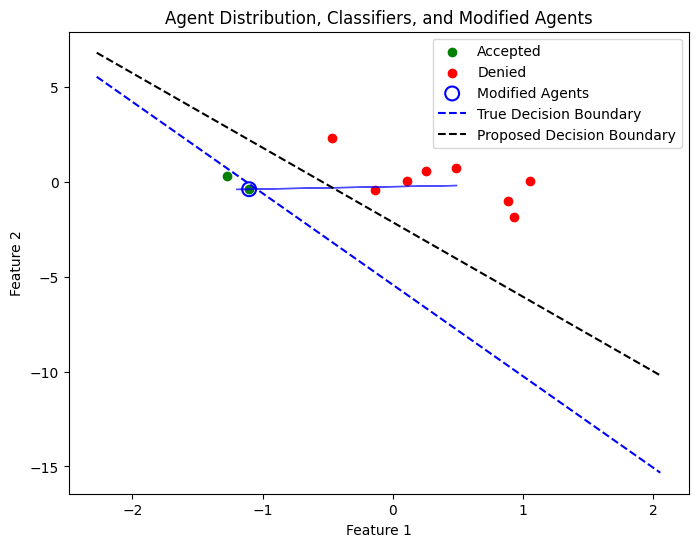

In [5]:
# ----------------------------
# Main: Running the Simulation with a Specific Seed
# ----------------------------
if __name__ == "__main__":
    # Set a specific seed for reproducibility.
    seed = 40  # Change this value to any desired seed.
    np.random.seed(seed)

    # Create a simulation environment with 2-dimensional features.
    env = SimulationEnv(hidden_dim=2,
                        num_agents=10,
                        cost_function='l1')

    # Run the exploration phase with a given exploration budget.
    exploration_cost = env.run_exploration_phase(exploration_budget= 9)
    print("Total Exploration Cost:", exploration_cost)

    # Run the exploitation phase.
    utilities = env.run_exploitation_phase()
    print("Utilities after exploitation phase (first 10 shown):", utilities[:10])

    # Plot the environment if hidden_dim == 2.
    env.plot_environment()

In [6]:

    #     # ----- New Section: Plot Total Utility as a Function of Exploration Budget -----
    # exploration_budgets = list(range(0, 21, 2))  # For example, budgets: 0, 2, 4, ..., 20
    # total_utilities = []
    # for budget in exploration_budgets:
    #     # For each exploration budget, create a new environment.
    #     env_temp = SimulationEnv(hidden_dim=2,
    #                              num_agents=50,
    #                              cost_function='l1')
    #     env_temp.run_exploration_phase(exploration_budget=budget)
    #     utilities_temp = env_temp.run_exploitation_phase()
    #     total_utilities.append(np.sum(utilities_temp))

    # plt.figure(figsize=(8, 6))
    # plt.plot(exploration_budgets, total_utilities, marker='o')
    # plt.xlabel('Exploration Budget')
    # plt.ylabel('Total Utility')
    # plt.title('Total Utility as a Function of Exploration Budget')
    # plt.grid(True)
    # plt.show()